# DSI37 Capstone Project: Skin Disease Classification Using Computer Vision

<a id='part_iii'></a>
[Part I](Part1-Intro_Eda.ipynb#part_i) <br>
[Part II](Part2-EfficientnetModel.ipynb#part_ii) <br>
[Part III](Part3-VggModel.ipynb#part_iii) <br>
[Part V](Part5-Ensemble_Insights_Recommendations.ipynb#part_v)

<a id='part_iv'></a>
# Part 4: Transfer Learning with ResNet152V2

## Contents
[1. Importing Libraries](#imports) <br>
[2. Importing and Preprocessing Data](#data) <br>
[3. Hyperparameter Tuning](#hypertuning) <br>
[4. Model](#model) <br>
[5. Fine Tuning](#finetuning) <br>

<a id='imports'></a>
## 1. Importing Libraries

In [1]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Pip install keras tuner
!pip install keras-tuner -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.1/176.1 kB 3.4 MB/s eta 0:00:00


In [3]:
# Import required libraries
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
import keras
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from tensorflow.keras.applications.efficientnet_v2 import EfficientNetV2L
from tensorflow.keras.applications.resnet_v2 import ResNet152V2
from tensorflow.keras.applications.vgg16 import VGG16
import keras_tuner
from keras_tuner.tuners import BayesianOptimization
from keras import Model, layers
from keras.models import Sequential
from keras.optimizers import Adam, SGD
from keras.layers import GlobalAveragePooling2D, Dropout, Dense, Input, Conv2D, MaxPooling2D, Flatten
from keras import backend as K

<a id='data'></a>
## 2. Importing and Preprocessing Data

In [4]:
# Setting directories
cwd = '/content/drive/MyDrive/Colab Notebooks/Capstone 3'
data_dir = '/content/drive/MyDrive/Colab Notebooks/Capstone 3/data'
model_dir = '/content/drive/MyDrive/Colab Notebooks/Capstone 3/models'

In [5]:
# Setting batch size and image size
batch_size = 32
img_height = 224
img_width = 224

# Creating train dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    labels='inferred',
    label_mode='categorical',
    batch_size=batch_size,
    image_size=(img_height, img_width),
    shuffle=True,
    seed=42,
    validation_split=0.2,
    subset='training'
)

# Creating validation dataset
val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    labels='inferred',
    label_mode='categorical',
    batch_size=batch_size,
    image_size=(img_height, img_width),
    shuffle=True,
    seed=42,
    validation_split=0.2,
    subset='validation'
)

Found 3265 files belonging to 5 classes.
Using 2612 files for training.
Found 3265 files belonging to 5 classes.
Using 653 files for validation.


In [6]:
# Get the class labels and number of classes from the dataset
class_labels = train_ds.class_names
num_classes = len(class_labels)
print('Class labels:', class_labels)
print("Number of classes:", num_classes)

# Create the inverse mapping of class indices to class labels
inv_map_classes = {i: label for i, label in enumerate(class_labels)}
map_classes = {label: i for i, label in enumerate(class_labels)}
print('Inverse mapping of classes:', inv_map_classes)
print('Mapping of classes:', map_classes)

Class labels: ['acne', 'eczema', 'fungal', 'psoriasis', 'warts']
Number of classes: 5
Inverse mapping of classes: {0: 'acne', 1: 'eczema', 2: 'fungal', 3: 'psoriasis', 4: 'warts'}
Mapping of classes: {'acne': 0, 'eczema': 1, 'fungal': 2, 'psoriasis': 3, 'warts': 4}


In [7]:
# Creating test dataset
val_batches = val_ds.cardinality()
test_ds = val_ds.take(val_batches // 5) # Moving 20% into test dataset
val_ds = val_ds.skip(val_batches // 5)
print('Number of validation batches: %d' % val_ds.cardinality())
print('Number of test batches: %d' % test_ds.cardinality())

Number of validation batches: 17
Number of test batches: 4


In [8]:
# Prepare all train/validation/test datasets
train_ds = train_ds.prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=tf.data.AUTOTUNE)

<a id='hypertuning'></a>
## 3. Hyperparameter Tuning

In [ ]:
# Data augmentation
def create_augmentation(level):
  """This function accepts a string argument to determine the level of data augmentation to apply"""
  if level == 'medium':
    data_augmentation = tf.keras.Sequential([
        layers.RandomRotation(factor=0.15),
        layers.RandomContrast(factor=0.1)
    ])
    return data_augmentation
  elif level == 'hard':
    data_augmentation = tf.keras.Sequential([
        layers.RandomRotation(factor=0.15),
        layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
        layers.RandomContrast(factor=0.1)
      ])
    return data_augmentation
  else:
    data_augmentation = tf.keras.Sequential([
        layers.RandomRotation(factor=0.15)
    ])
    return data_augmentation

In [ ]:
# Modifying HyperModel subclass
class ResHyperModel(keras_tuner.HyperModel):
    def build(self, hp):
      # Load base model
      base_model = ResNet152V2(weights='imagenet',
                               include_top=False,
                               input_shape=(img_height, img_width, 3))

      # Freeze the base model weights
      base_model.trainable = False

      # Specify model architecture (Feature extraction)
      inputs = keras.Input(shape=(img_height, img_width, 3))
      x = keras.applications.resnet_v2.preprocess_input(inputs)
      # Tune Data Augmentation
      augment_level = hp.Choice('augment', ['soft', 'medium', 'hard'])
      x = create_augmentation(augment_level)(x)
      x = base_model(x, training=False)
      # Tune GlobalPooling vs Flatten
      if hp.Boolean('GlobalPool'):
        x = GlobalAveragePooling2D()(x)
      else:
        x = Flatten()(x)
      # Tune number of Dense layers
      if hp.Boolean('fc1'):
        # Tune number of units in the Dense layer
        x = Dense(units=hp.Int('units_1', 64, 1028, step=64), activation='relu')(x)
      # Tune batch normalization
      if hp.Boolean('batch_norm'):
        x = layers.BatchNormalization()(x)
      # Tune dropout rate
      x = Dropout(hp.Float('dropout', min_value= 0.0, max_value=0.5, step= 0.1))(x)
      outputs = Dense(num_classes, activation='softmax')(x)
      model = Model(inputs, outputs)

      # Tune the optimizer
      optimizer = hp.Choice('optim', ['adam', 'sgd'])

      if optimizer=='sgd':
        optimizer = keras.optimizers.SGD(momentum=0.9, nesterov=True)
      else:
        optimizer = keras.optimizers.Adam()

      model.compile(optimizer=optimizer,
                    loss='categorical_crossentropy',
                    metrics=['accuracy'])

      # Tune learning rate
      learning_rate = hp.Float('lr', min_value=1e-3, max_value=1e-2, sampling='log')
      K.set_value(model.optimizer.learning_rate, learning_rate)

      return model

    def fit(self, hp, model, x, validation_data, *args, **kwargs):
        return model.fit(train_ds,
                         validation_data=val_ds,
                         *args,
                         **kwargs)

In [ ]:
# Specifying tuner settings
tuner = BayesianOptimization(hypermodel=ResHyperModel(),
                            objective='val_accuracy',
                            max_trials=15,
                            overwrite=True,
                            directory="/content/drive/MyDrive/Colab Notebooks/Capstone 3/reshypermodel",
                            project_name="/content/drive/MyDrive/Colab Notebooks/Capstone 3/reshypermodel/bayesian")

In [ ]:
# Print summary of search space
tuner.search_space_summary()

Search space summary
Default search space size: 7
augment (Choice)
{'default': 'soft', 'conditions': [], 'values': ['soft', 'medium', 'hard'], 'ordered': False}
GlobalPool (Boolean)
{'default': False, 'conditions': []}
fc1 (Boolean)
{'default': False, 'conditions': []}
batch_norm (Boolean)
{'default': False, 'conditions': []}
dropout (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.1, 'sampling': 'linear'}
optim (Choice)
{'default': 'adam', 'conditions': [], 'values': ['adam', 'sgd'], 'ordered': False}
lr (Float)
{'default': 0.001, 'conditions': [], 'min_value': 0.001, 'max_value': 0.01, 'step': None, 'sampling': 'log'}


In [ ]:
# Set earlystopping
earlystopping = EarlyStopping(monitor="val_loss",
                              mode="min",
                              patience = 6,
                              verbose=1)

# Running keras tuner
tuner.search(x=train_ds,
             epochs=20,
             validation_data=val_ds,
             callbacks=[earlystopping],
             verbose=1)

Trial 15 Complete [00h 03m 23s]
val_accuracy: 0.5333333611488342

Best val_accuracy So Far: 0.7219047546386719
Total elapsed time: 01h 11m 28s


In [ ]:
# Show result summary of top trials
tuner.results_summary()

Results summary
Results in /content/drive/MyDrive/Colab Notebooks/Capstone 3/reshypermodel/bayesian
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 02 summary
Hyperparameters:
augment: soft
GlobalPool: True
fc1: True
batch_norm: False
dropout: 0.0
optim: adam
lr: 0.0030542764550831637
units_1: 832
Score: 0.7219047546386719

Trial 01 summary
Hyperparameters:
augment: soft
GlobalPool: True
fc1: True
batch_norm: True
dropout: 0.1
optim: adam
lr: 0.0015921417834847884
units_1: 1024
Score: 0.7200000286102295

Trial 03 summary
Hyperparameters:
augment: soft
GlobalPool: False
fc1: False
batch_norm: True
dropout: 0.4
optim: sgd
lr: 0.004516568787507474
units_1: 384
Score: 0.6742857098579407

Trial 10 summary
Hyperparameters:
augment: soft
GlobalPool: False
fc1: False
batch_norm: False
dropout: 0.1
optim: sgd
lr: 0.003153646935718524
units_1: 896
Score: 0.6723809242248535

Trial 04 summary
Hyperparameters:
augment: medium
GlobalPool: True
fc1: True
batch_norm: True

In [ ]:
# Define function to update results of hypertuning
def update_results(num_trials, network):
  """This functions takes 2 inputs and returns a dataframe containing the scores and hyperparameters used in each trial
  num_trials (int) should be the number of trials conducted
  network (str) should be the network architecture used
  """
  trial_df = pd.DataFrame(columns=['network', 'augment', 'GlobalPool', 'units_1', 'batch_norm', 'dropout', 'optim', 'lr', 'score'])
  trials = [str(number).zfill(2) for number in range(num_trials)]
  for i, trial in enumerate(trials):
    df = pd.read_json('/content/drive/MyDrive/Colab Notebooks/Capstone 3/reshypermodel/bayesian/trial_' + trial + '/trial.json')
    metrics_dict = df.loc['values', 'hyperparameters']
    metrics_dict['score'] = df.loc['values', 'score']
    metrics_df = pd.DataFrame(metrics_dict, index=[i])
    metrics_df['network'] = network
    trial_df = pd.concat([trial_df, metrics_df])
  return trial_df

In [ ]:
# Update results
trial_df = update_results(15, 'Resnet')
trial_df.to_csv('/content/drive/MyDrive/Colab Notebooks/Capstone 3/dataframes/resnet_hypertuning.csv', index=False)

<ipython-input-27-43c1ec87ed95>:11: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  trial_df = pd.concat([trial_df, metrics_df])
<ipython-input-27-43c1ec87ed95>:11: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  trial_df = pd.concat([trial_df, metrics_df])
<ipython-input-27-43c1ec87ed95>:11: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  trial_df = pd.concat([trial_df, metrics_df])
<ipython-input-27-43c1ec87ed95>:11: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  trial_df = pd.concat(

In [ ]:
# Display summary of hyperparameter tuning
display(trial_df.sort_values(by='score', ascending=False))

,network,augment,GlobalPool,units_1,batch_norm,dropout,optim,lr,score,fc1
2,Resnet,soft,True,832,False,0.0,adam,0.003054,0.721905,True
1,Resnet,soft,True,1024,True,0.1,adam,0.001592,0.720000,True
3,Resnet,soft,False,384,True,0.4,sgd,0.004517,0.674286,False
10,Resnet,soft,False,896,False,0.1,sgd,0.003154,0.672381,False
4,Resnet,medium,True,128,True,0.1,adam,0.004210,0.607619,True
13,Resnet,medium,False,640,False,0.0,adam,0.003239,0.582857,False
12,Resnet,medium,False,576,False,0.0,adam,0.005020,0.580952,True
7,Resnet,medium,False,192,False,0.0,sgd,0.003574,0.571429,True
5,Resnet,medium,True,192,False,0.3,adam,0.005104,0.569524,True
11,Resnet,hard,False,832,True,0.1,sgd,0.002635,0.556190,False


<a id='model'></a>
## 4. Model

In [ ]:
# Build the model with the best hyper parameters
best_hps = tuner.get_best_hyperparameters(3)[0]
h_model = ResHyperModel()
res_model = h_model.build(best_hps)

# Display summary of best model
display(res_model.summary())

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.math.truediv_1 (TFOpLamb  (None, 224, 224, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_1 (TFOpLam  (None, 224, 224, 3)      0         
 bda)                                                            
                                                                 
 sequential_1 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 resnet152v2 (Functional)    (None, 7, 7, 2048)        58331648  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0   

None

In [ ]:
# Define function to obtain callbacks
def get_callbacks(model_file, patience, lr_factor):
  ''' Callbacks used for saving the best weights, early stopping and learning rate scheduling.
  - model_file (str) is the file name for the saved model in the form of {file_name.h5}
  - patience (int) is the patience used for early stopping and learning rate scheduling
  - lr_factor (float) is the factor used to reduce the learning rate when val_loss has not decreased for patience//2 epochs
  '''

  modelcheckpoint = ModelCheckpoint(os.path.join(model_dir, model_file),
                                    monitor='val_accuracy',
                                    mode="max",
                                    save_best_only=True,
                                    save_weights_only=False)

  earlystop = EarlyStopping(monitor="val_loss",
                            mode="min",
                            patience = patience,
                            verbose=1)

  reducelronplateau = ReduceLROnPlateau(monitor="val_loss",
                                        mode="min",
                                        factor=lr_factor,
                                        min_lr=1e-6,
                                        patience=patience//2,
                                        verbose=1)

  return [modelcheckpoint, earlystop, reducelronplateau]

In [ ]:
# Specify callbacks
callback_list = get_callbacks('res_model.h5',
                              patience=10,
                              lr_factor=0.1)

# Fitting the model
res_history = res_model.fit(train_ds,
                            epochs = 30,
                            validation_data=val_ds,
                            callbacks=callback_list,
                            verbose=1)

Epoch 1/30
82/82 [==============================] - 35s 319ms/step - loss: 1.6236 - accuracy: 0.5295 - val_loss: 0.9173 - val_accuracy: 0.6286 - lr: 0.0031
Epoch 2/30
82/82 [==============================] - 23s 278ms/step - loss: 0.8315 - accuracy: 0.6593 - val_loss: 0.9702 - val_accuracy: 0.6019 - lr: 0.0031
Epoch 3/30
82/82 [==============================] - 27s 325ms/step - loss: 0.7358 - accuracy: 0.6941 - val_loss: 0.8538 - val_accuracy: 0.6495 - lr: 0.0031
Epoch 4/30
82/82 [==============================] - 27s 320ms/step - loss: 0.6683 - accuracy: 0.7224 - val_loss: 0.8011 - val_accuracy: 0.6781 - lr: 0.0031
Epoch 5/30
82/82 [==============================] - 27s 319ms/step - loss: 0.6022 - accuracy: 0.7557 - val_loss: 0.7847 - val_accuracy: 0.6857 - lr: 0.0031
Epoch 6/30
82/82 [==============================] - 25s 289ms/step - loss: 0.5339 - accuracy: 0.7906 - val_loss: 0.9255 - val_accuracy: 0.6705 - lr: 0.0031
Epoch 7/30
82/82 [==============================] - 23s 272ms/st

In [ ]:
# Define function to plot history of deep learning
def plot_history(history, title):
  """This function plots the train and validation accuracies and losses in two separate graphs
  history is the output of model.fit
  title (str) is the intended super title of the figure
  """
  plt.figure(figsize=(8, 8))
  color = sns.color_palette()

  plt.subplot(1, 2, 1)
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  epochs = range(len(acc))


  sns.lineplot(x=epochs, y=acc, label='Training Accuracy')
  sns.lineplot(x=epochs, y=val_acc, label='Validation Accuracy')
  plt.title('Training and Validation Accuracy')
  plt.legend(loc='lower right')

  plt.subplot(1, 2, 2)
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  epochs = range(len(loss))

  sns.lineplot(x=epochs, y=loss, label='Training Loss')
  sns.lineplot(x=epochs, y=val_loss, label='Validation Loss')
  plt.title('Training and Validation Loss')
  plt.legend(loc='upper right')
  plt.suptitle(title)
  plt.show()

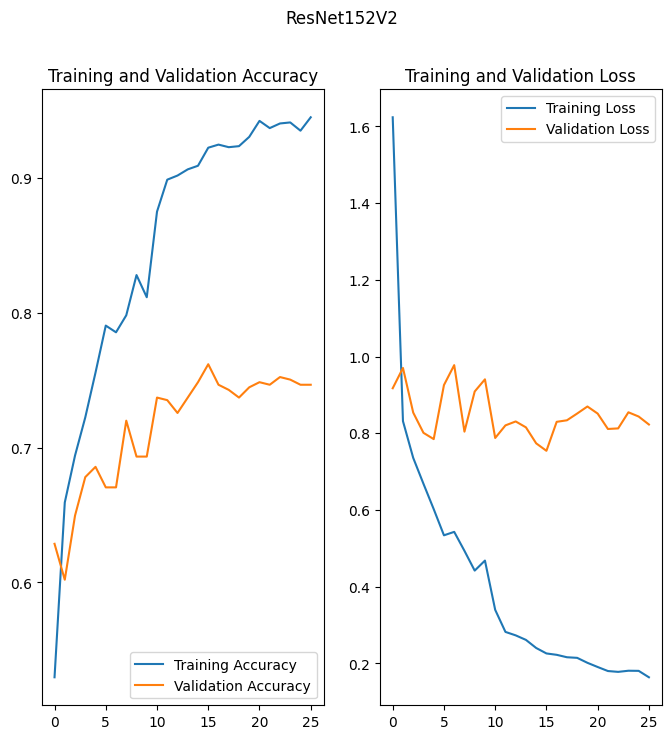

In [ ]:
# Plot history
plot_history(res_history, 'ResNet152V2')

In [9]:
# Load best model
res_model = keras.models.load_model(os.path.join(model_dir, 'res_model.h5'))

In [ ]:
# Train and test accuracies
res_train_acc = res_model.evaluate(train_ds)
res_test_acc = res_model.evaluate(test_ds)
print('Train Accuracy: {:.2f}'.format(res_train_acc[1]))
print('Test Accuracy: {:.2f}'.format(res_test_acc[1]))

4/4 [==============================] - 1s 222ms/step - loss: 0.7725 - accuracy: 0.7969
Train Accuracy: 0.91
Test Accuracy: 0.80


In [11]:
# Generate predictions and labels
test_labels =  []
test_preds = []
for image, label in test_ds.unbatch():
  prediction = np.argmax(res_model.predict(np.expand_dims(image, 0), verbose=0))
  test_preds.append(prediction)
  test_labels.append(np.argmax(label))

In [ ]:
# Classification Report for ResNet152V2
print(classification_report(test_labels, test_preds, target_names=class_labels))

              precision    recall  f1-score   support

        acne       1.00      1.00      1.00        13
      eczema       0.74      0.76      0.75        41
      fungal       0.68      0.63      0.66        30
   psoriasis       0.70      0.64      0.67        22
       warts       0.72      0.82      0.77        22

    accuracy                           0.74       128
   macro avg       0.77      0.77      0.77       128
weighted avg       0.74      0.74      0.74       128



In [13]:
# Defining function to plot confusion matrix
def plot_heatmap(y_true, y_pred, class_names, title):
    plt.figure(figsize=(10,10))
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(
        cm,
        annot=True,
        square=True,
        xticklabels=class_names,
        yticklabels=class_names,
        fmt='d',
        cmap=plt.cm.Blues,
        cbar=True)

    plt.title(title, fontsize=16)
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.show()

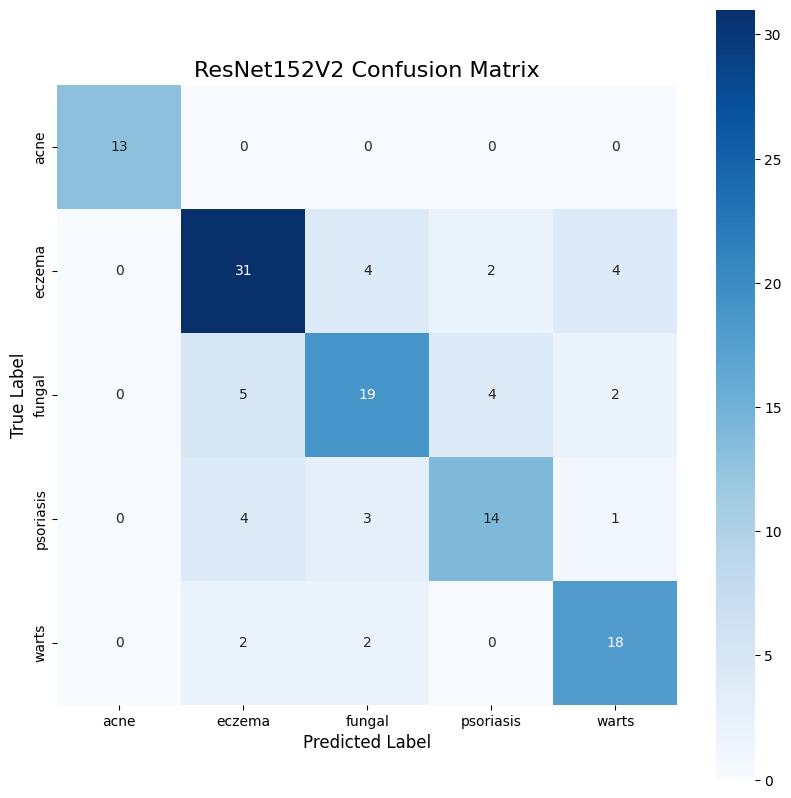

In [ ]:
# Confusion Matrix for ResNet152V2
plot_heatmap(test_labels, test_preds, class_labels, title="ResNet152V2 Confusion Matrix")

<a id='finetuning'></a>
## 5. Fine Tuning

In [15]:
# Check base model layer names and trainable status
for layer in res_model.layers[4].layers:
  print(layer.name, layer.trainable)

input_3 True
conv1_pad False
conv1_conv False
pool1_pad False
pool1_pool False
conv2_block1_preact_bn False
conv2_block1_preact_relu False
conv2_block1_1_conv False
conv2_block1_1_bn False
conv2_block1_1_relu False
conv2_block1_2_pad False
conv2_block1_2_conv False
conv2_block1_2_bn False
conv2_block1_2_relu False
conv2_block1_0_conv False
conv2_block1_3_conv False
conv2_block1_out False
conv2_block2_preact_bn False
conv2_block2_preact_relu False
conv2_block2_1_conv False
conv2_block2_1_bn False
conv2_block2_1_relu False
conv2_block2_2_pad False
conv2_block2_2_conv False
conv2_block2_2_bn False
conv2_block2_2_relu False
conv2_block2_3_conv False
conv2_block2_out False
conv2_block3_preact_bn False
conv2_block3_preact_relu False
conv2_block3_1_conv False
conv2_block3_1_bn False
conv2_block3_1_relu False
conv2_block3_2_pad False
conv2_block3_2_conv False
conv2_block3_2_bn False
conv2_block3_2_relu False
max_pooling2d_3 False
conv2_block3_3_conv False
conv2_block3_out False
conv3_block1_pr

In [16]:
# Set layers after block 5 to be trainable
start_layer_name = 'conv5_block1_preact_relu'
unfreeze = False

for layer in res_model.layers[4].layers:
  if start_layer_name in layer.name:
    unfreeze=True
  if unfreeze:
    if not isinstance(layer, layers.BatchNormalization):
      layer.trainable = True

In [17]:
# Recheck that only layers after block 5 are trainable
for layer in res_model.layers[4].layers:
  print(layer.name, layer.trainable)

input_3 True
conv1_pad False
conv1_conv False
pool1_pad False
pool1_pool False
conv2_block1_preact_bn False
conv2_block1_preact_relu False
conv2_block1_1_conv False
conv2_block1_1_bn False
conv2_block1_1_relu False
conv2_block1_2_pad False
conv2_block1_2_conv False
conv2_block1_2_bn False
conv2_block1_2_relu False
conv2_block1_0_conv False
conv2_block1_3_conv False
conv2_block1_out False
conv2_block2_preact_bn False
conv2_block2_preact_relu False
conv2_block2_1_conv False
conv2_block2_1_bn False
conv2_block2_1_relu False
conv2_block2_2_pad False
conv2_block2_2_conv False
conv2_block2_2_bn False
conv2_block2_2_relu False
conv2_block2_3_conv False
conv2_block2_out False
conv2_block3_preact_bn False
conv2_block3_preact_relu False
conv2_block3_1_conv False
conv2_block3_1_bn False
conv2_block3_1_relu False
conv2_block3_2_pad False
conv2_block3_2_conv False
conv2_block3_2_bn False
conv2_block3_2_relu False
max_pooling2d_3 False
conv2_block3_3_conv False
conv2_block3_out False
conv3_block1_pr

In [ ]:
# Compile at a lower learning rate
res_model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-4),
                   loss='categorical_crossentropy',
                   metrics=['accuracy']
                  )

In [ ]:
# Specify callbacks
callback_list = get_callbacks('res_fine.h5',
                              patience=6,
                              lr_factor=0.1)

# Fine tune model
res_fine_history = res_model.fit(train_ds,
                                 epochs=10,
                                 validation_data=val_ds,
                                 verbose=1,
                                 callbacks=callback_list)

Epoch 1/10
82/82 [==============================] - 43s 410ms/step - loss: 0.5613 - accuracy: 0.7841 - val_loss: 0.7177 - val_accuracy: 0.7486 - lr: 1.0000e-04
Epoch 2/10
82/82 [==============================] - 26s 306ms/step - loss: 0.3754 - accuracy: 0.8606 - val_loss: 0.7960 - val_accuracy: 0.7486 - lr: 1.0000e-04
Epoch 3/10
82/82 [==============================] - 26s 309ms/step - loss: 0.3083 - accuracy: 0.8897 - val_loss: 0.8829 - val_accuracy: 0.7371 - lr: 1.0000e-04
Epoch 4/10
82/82 [==============================] - 32s 384ms/step - loss: 0.2764 - accuracy: 0.8989 - val_loss: 0.7069 - val_accuracy: 0.7752 - lr: 1.0000e-04
Epoch 5/10
82/82 [==============================] - 33s 382ms/step - loss: 0.2026 - accuracy: 0.9357 - val_loss: 0.8052 - val_accuracy: 0.7810 - lr: 1.0000e-04
Epoch 6/10
82/82 [==============================] - 32s 366ms/step - loss: 0.1784 - accuracy: 0.9414 - val_loss: 0.7042 - val_accuracy: 0.8019 - lr: 1.0000e-04
Epoch 7/10
82/82 [======================

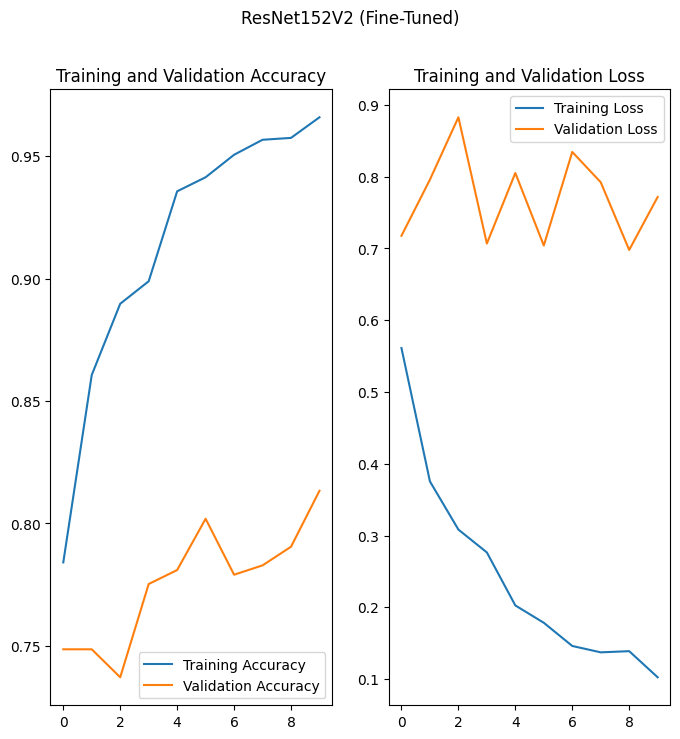

In [ ]:
# Plot history
plot_history(res_fine_history, 'ResNet152V2 (Fine-Tuned)')

In [18]:
# Load best model
res_model = keras.models.load_model(os.path.join(model_dir, 'res_fine.h5'))

In [ ]:
# Train and test accuracies
res_fine_train_acc = res_model.evaluate(train_ds)
res_fine_test_acc = res_model.evaluate(test_ds)
print('Train Accuracy: {:.2f}'.format(res_fine_train_acc[1]))
print('Test Accuracy: {:.2f}'.format(res_fine_test_acc[1]))

4/4 [==============================] - 1s 220ms/step - loss: 0.5297 - accuracy: 0.8203
Train Accuracy: 0.98
Test Accuracy: 0.82


In [20]:
# Generate predictions and labels
test_labels =  []
test_preds = []
for image, label in test_ds.unbatch():
  prediction = np.argmax(res_model.predict(np.expand_dims(image, 0), verbose=0))
  test_preds.append(prediction)
  test_labels.append(np.argmax(label))

In [ ]:
# Classification Report for ResNet152V2 (Fine-tuned)
print(classification_report(test_labels, test_preds, target_names=class_labels))

              precision    recall  f1-score   support

        acne       1.00      1.00      1.00        11
      eczema       0.86      0.91      0.89        47
      fungal       0.81      0.88      0.84        33
   psoriasis       1.00      0.76      0.87        17
       warts       0.94      0.85      0.89        20

    accuracy                           0.88       128
   macro avg       0.92      0.88      0.90       128
weighted avg       0.89      0.88      0.88       128



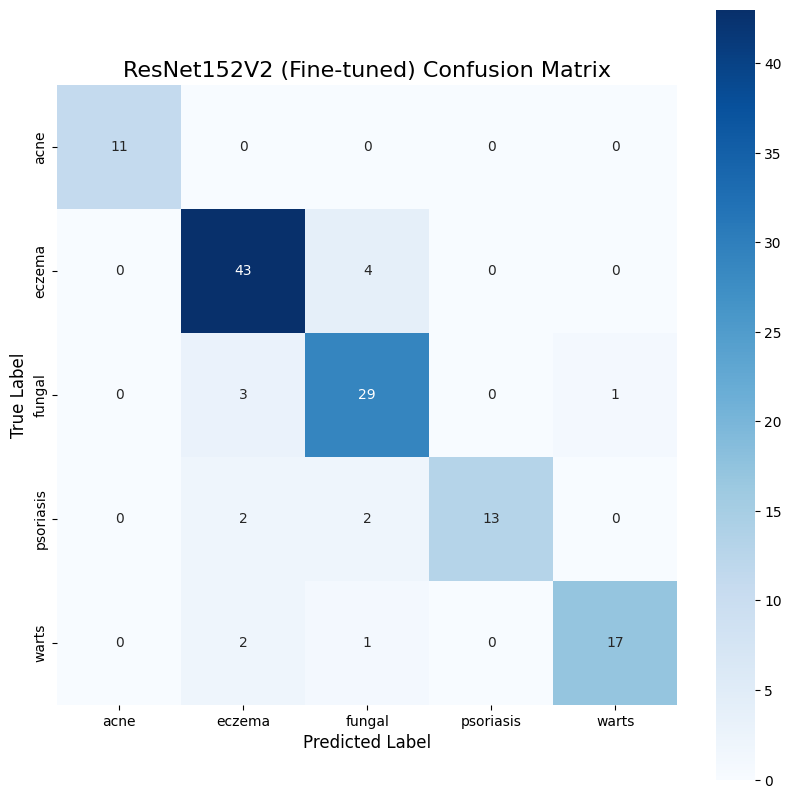

In [ ]:
# Confusion Matrix for ResNet152V2 (Fine-tuned)
plot_heatmap(test_labels, test_preds, class_labels, title="ResNet152V2 (Fine-tuned) Confusion Matrix")

### Models Summary

|Model|Train Accuracy|Test Accuracy|
|:---|:---:|:---|
|<b>EfficientNetB1 (Baseline Model)</b>|0.89|0.78|
|<b>EfficientNetB1 Fine-Tuned</b>|0.93|0.88|
|<b>VGG16</b>|0.96|0.81|
|<b>VGG16 Fine-Tuned|0.99|0.85|
|<b>ResNet152V2</b>|0.91|0.80|
|<b>ResNet152V2 Fine-Tuned|0.98|0.82|